# Predictive Process Monitoring - Outcome Prediction

This notebook is part of the [starter package](https://github.com/fmannhardt/starter-predictive-process-monitoring) for predictive process monitoring. It contains an example of a prediction model for the purpose of developing and applying predictive process monitoring techniques.

## Setup
The following Python libraries are used, please refer to the installation instructions to prepare your environment:

* [PM4Py](https://pm4py.fit.fraunhofer.de/)
* [Pandas](https://pandas.pydata.org/)
* [Numpy](https://numpy.org/)
* [PyTorch](https://pytorch.org/)

In [1]:
import pandas as pd
import pm4py
import numpy as np
import sklearn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

## Event Log & Data Loading

We continue with bag-of-words or multiset of events model encoding generated in the [previous notebook](./1_feature_extraction.ipynb). Making use of the other encodings and adding others is left as exercise. 

In [2]:
from urllib.request import urlretrieve
import os

# download from 4tu.nl
urlretrieve('https://data.4tu.nl/file/33632f3c-5c48-40cf-8d8f-2db57f5a6ce7/643dccf2-985a-459e-835c-a82bce1c0339', 'sepsis2.xes.gz')
sepsis_log = pm4py.read_xes('sepsis2.xes.gz')
os.unlink('sepsis2.xes.gz') # clean up

# Here we want the multiset (or rather list) of sequences view on logs
from pm4py.objects.conversion.log import converter as log_conversion
sepsis_log = log_conversion.apply(sepsis_log, {}, log_conversion.TO_EVENT_LOG)

sepsis_returns = [len(list(filter(lambda e: e["concept:name"] == "Return ER" ,trace))) > 0 for trace in sepsis_log]
sepsis_log = pm4py.filter_event_attribute_values(sepsis_log, "concept:name", "Return ER", level = "event", retain=False)
from pm4py.objects.log.obj import EventLog, Trace
sepsis_prefixes = EventLog([Trace(trace[0:10], attributes = trace.attributes) for trace in sepsis_log])

sepsis_df = pm4py.convert_to_dataframe(sepsis_prefixes)
sepsis_act_count = sepsis_df.loc[:,["case:concept:name", "concept:name"]].groupby(["case:concept:name", "concept:name"],sort=False).size()
sepsis_bag = np.asarray(sepsis_act_count.unstack(fill_value=0))
sepsis_bag.shape

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

(1050, 14)

## Prediction

Let us try to build a basic prediction model based on this information. In this example, we aim to predict the binary outcome whether the event `Return ER` occurred or not. 

**Disclaimer: here *basic* means that the model and encoding is not expected to be of any quality. Also note that the prediction task, while useful, may not be feasible based on the prefix encoding that we chose. Treat the following code as an example and starting point only!**

### Data Preparation

#### Target Variable

Let us look at the distribution of the target variable.

In [3]:
np.unique(sepsis_returns, return_counts=True)

(array([False,  True]), array([756, 294]))

In [4]:
# For future processing we need 0 and 1 instead of True and False
sepsis_returns = np.asarray(sepsis_returns).astype(int)
sepsis_returns.shape

(1050,)

#### Data Scaling & Loading

This often helps prediction models to perform better.

**Important:** make sure to not compute the scaling with the test set included since there is a risk of data leakage otherwise. In other words, the test set should be separated before any pre-processing, which may use a property of the dataset, is applied. Of course, the test set is scaled as well but with the scaler *trained* only on the training set. 

In [5]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(sepsis_bag)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(sepsis_returns.reshape(-1, 1))

### Model Definition

Let's define a simple network and try to overfit. We make use of PyTorch to build a simple Neural Network. 

**Disclaimer: Again, this is just a simple example and not in anyway meant as a recommendation for a model.**

In [6]:
class NeuralNetworkBinaryOutcome(nn.Module):
    def __init__(self):
        super(NeuralNetworkBinaryOutcome, self).__init__()
        self.linear_relu_stack = nn.Sequential(            
            torch.nn.Linear(x.shape[1], 64),
            nn.BatchNorm1d(num_features=64),
            nn.LeakyReLU(),            
            torch.nn.Linear(64, 128),
            nn.BatchNorm1d(num_features=128),          
            torch.nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

We use a standard training loop in PyTorch:

In [7]:
def train(dataloader, model, 
          loss_fn, measure_fn, 
          optimizer, device, epochs): 
    
    losses = []
    size = len(dataloader.dataset)
    
    loop = tqdm(range(epochs))
    
    for epoch in loop:
    
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction error
            pred = model(X)
            
            loss = loss_fn(pred, y)
            measure = measure_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            
            losses.append([loss.item(), measure.item()])
            
        loop.set_description('Epoch {}/{}'.format(epoch + 1, epochs))
        loop.set_postfix(loss=loss.item(), measure=measure.item())
    
    return losses

And can use the following function to get all evaluation results:

In [8]:
def evaluate_all(dataloader, model, device):    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    
    result = []
    original = []

    with torch.no_grad(): 
        for X, y in tqdm(dataloader):  
            X, y = X.to(device), y.to(device) 
            pred = model(X)          
                        
            result.extend(pred.flatten().numpy())
            original.extend(y.flatten().numpy())
                           
    return np.asarray(result), np.asarray(original)

### Training

Prepare the data for the PyTorch data loading mechanism.

In [9]:
from torch.utils.data import TensorDataset, DataLoader

# We need float32 data
x = torch.from_numpy(data_scaled.astype('float32'))
y = torch.from_numpy(target_scaled.astype('float32'))

# Always check the shapes
print(x.shape)
print(y.shape)

ds = TensorDataset(x, y)
train_dataloader = DataLoader(ds, batch_size=64, shuffle=True)

torch.Size([1050, 14])
torch.Size([1050, 1])


Let us check a random single sample from our data loader (always a good idea!) 

In [10]:
inputs, classes = next(iter(train_dataloader))
print(inputs[0])
print(classes[0])

tensor([0.0000, 0.2000, 0.5000, 0.3333, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        0.0000, 0.5000, 0.0000, 0.0000, 0.0000])
tensor([0.])


We train the model using cross entropy as loss function accuracy as easier to interpret measure to report.

In [11]:
## if you want ot use a GPU you need to tweak the requirements.txt to include the GPU-enabled PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# fix a seed to get reproducible results
torch.manual_seed(42)

model = NeuralNetworkBinaryOutcome().to(device)
print(model)

def get_accuracy(y_prob, y_true):    
    y_true = y_true.flatten()
    y_prob = y_prob.flatten()
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum() / y_true.size(0)
measure_fn = get_accuracy

results = train(train_dataloader, model, 
                nn.BCELoss(), # crossentropy for binary target 
                get_accuracy, 
                torch.optim.Adam(model.parameters()), 
                device, 100)

Using cpu device
NeuralNetworkBinaryOutcome(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

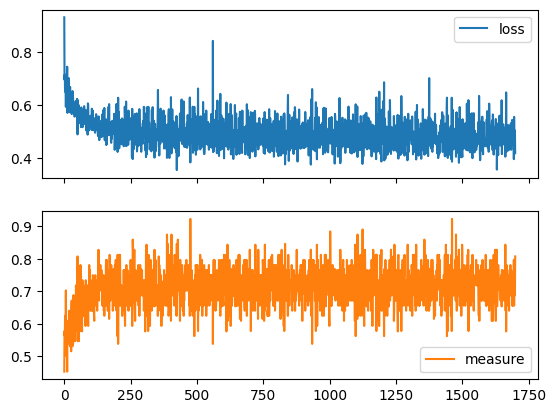

In [12]:
%matplotlib inline

results_data = pd.DataFrame(results)
results_data.columns = ['loss', 'measure']
ax = results_data.plot(subplots=True);

In [13]:
print("Accuracy: " + str(results[len(results)-1][1]))

true_returns = np.unique(sepsis_returns, return_counts= True)[1][0]
true_not_returns = np.unique(sepsis_returns, return_counts= True)[1][1]

print("Accuracy (never returns)" + str(true_returns / len(sepsis_returns)))
print("Accuracy (always returns)" + str(true_not_returns / len(sepsis_returns)))

Accuracy: 0.807692289352417
Accuracy (never returns)0.72
Accuracy (always returns)0.28


## Brief Evaluation

Ok, that is a bit better compared to simply always saying that the patient does not return. But the accuracy on the training set (**not even considering a test set!**) is still varying a lot and the variation of the log and accuracy over the epochs trained does not look good either. So, let us still have a look at the individual predictions and their score depending on the ground truth.

In [14]:
test_dataloader = DataLoader(ds, batch_size=256, shuffle=False)
result, original = evaluate_all(test_dataloader, model, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Score')

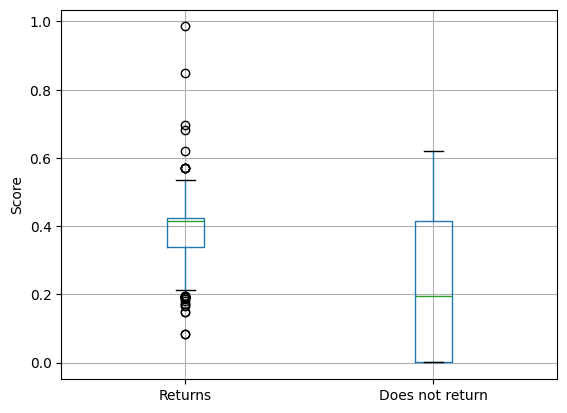

In [15]:
pd_pos = pd.DataFrame({'Returns': result[original == 1]})
pd_neg = pd.DataFrame({'Does not return': result[original == 0]})
pd.concat([pd_pos, pd_neg],axis=1).boxplot().set_ylabel('Score')

There seems to be some separation but likely the prediction model will give us many false positives when used to identify returning patients in practice.

**Of course, you should now compute the usual measures for classification tasks and the threshold for making a decision: recall, precision, confusion matrices, area under the curve and many other ways to deeply evaluate a prediction model. Always consider what would be the use case of your prediction.**

Why is this so bad? Let us have a look at the data distribution we put in:

Text(0, 0.5, 'Frequency')

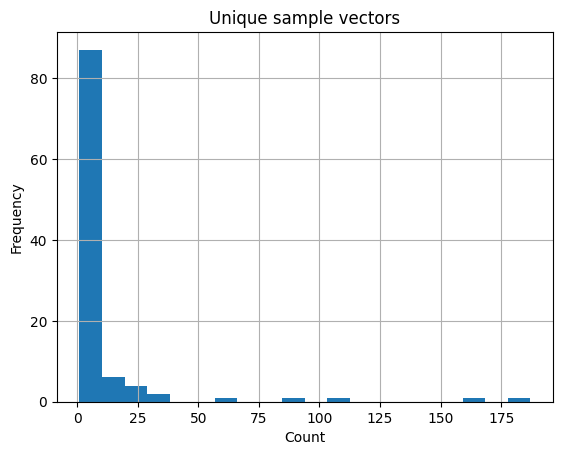

In [16]:
# count the unique vectors
dist_bags = np.unique(sepsis_bag, return_counts=True, axis=0)

# sort them with numpy
unique_vectors = dist_bags[0][np.argsort(-dist_bags[1])]
count_vectors = dist_bags[1][np.argsort(-dist_bags[1])]


hist = pd.DataFrame({'Unique sample vectors': count_vectors}).hist(bins = 20)[0][0]
hist.set_xlabel("Count")
hist.set_ylabel("Frequency")

Many of the traces result in the exact same sample. Let us check what is the "return status" for the most common sample that represents more than 175 traces.

In [17]:
# most frequently used vector
unique_vectors[0]

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [18]:
# find the sample indicies for this vector
sample_indicies = np.where((sepsis_bag == unique_vectors[0]).all(axis=1)) 
sample_results = target_scaled[sample_indicies]

In [19]:
np.unique(sample_results, return_counts=True)

(array([0, 1]), array([111,  76]))

It is clear that, without additional information, there is nothing the prediction model can learn to represent this division for the exact same feature values. We can look at further examples, but it seems we simply cannot reliably predict whether a patient will return from the bag-of-words / multiset of events model in the Sepsis event log.

This was just an example on how to use a predictive model with an event log to predict a binary process characteristic based on events contained in the event log.